In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
from scipy.optimize import minimize_scalar

In [93]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [94]:
#Lines from the excel
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\lineas_2.0.xlsx", skiprows=6, usecols=[0], names=['lambda'])
raw_lambda

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
951,10472.5230
952,10535.1220
953,10558.5430
954,10580.0390


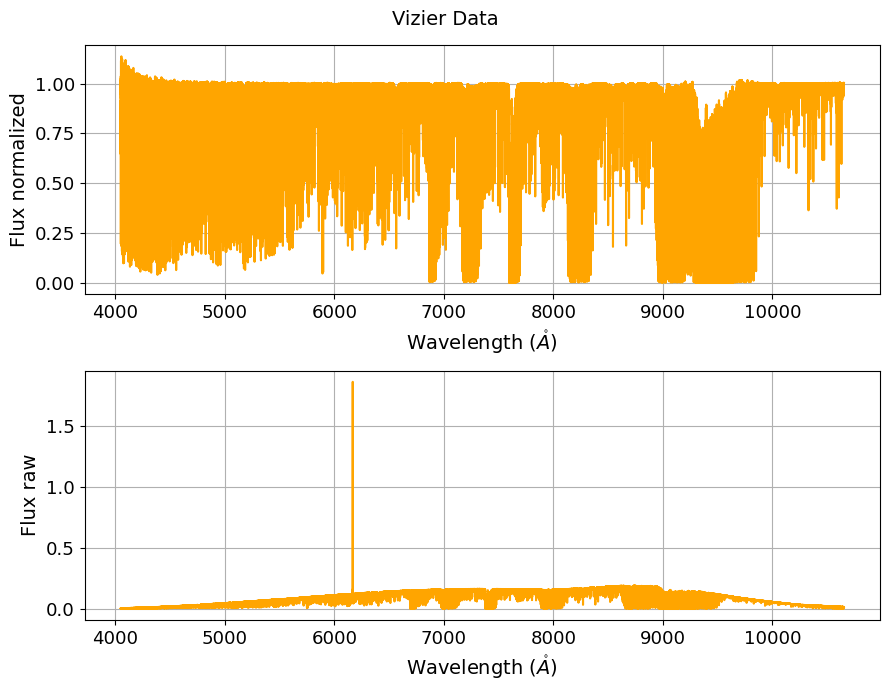

In [95]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Wavelength classification

In [96]:
#The one is for the function, between work like < or > but not the equal
data_4000_5000 = raw_data[raw_data['Wave A'].between(4000, 5000, inclusive='neither')]
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000, 6000, inclusive='neither')]
data_6000_7000 = raw_data[raw_data['Wave A'].between(6000, 7000, inclusive='neither')]
data_7000_8000 = raw_data[raw_data['Wave A'].between(7000, 8000, inclusive='neither')]
data_8000_9000 = raw_data[raw_data['Wave A'].between(8000, 9000, inclusive='neither')]
data_9000_10000 = raw_data[raw_data['Wave A'].between(9000, 10000, inclusive='neither')]
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')]

data_10000_11000

,Wave (cm),nFlux,rFlux,Wave A
3894770,9999.998584,0.996400,0.054332,10000.001416
3894771,9999.994818,0.996395,0.054278,10000.005182
3894772,9999.991051,0.996143,0.054249,10000.008949
3894773,9999.987285,0.995631,0.054277,10000.012715
3894774,9999.983518,0.994893,0.054311,10000.016482
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [97]:
#Now from lambda
lambda_4000_5000 = raw_lambda[raw_lambda['lambda'].between(4000, 5000, inclusive='neither')]
lambda_5000_6000 = raw_lambda[raw_lambda['lambda'].between(5000, 6000, inclusive='neither')]
lambda_6000_7000 = raw_lambda[raw_lambda['lambda'].between(6000, 7000, inclusive='neither')]
lambda_7000_8000 = raw_lambda[raw_lambda['lambda'].between(7000, 8000, inclusive='neither')]
lambda_8000_9000 = raw_lambda[raw_lambda['lambda'].between(8000, 9000, inclusive='neither')]
lambda_9000_10000 = raw_lambda[raw_lambda['lambda'].between(9000, 10000, inclusive='neither')]
lambda_10000_11000 = raw_lambda[raw_lambda['lambda'].between(10000, 11000, inclusive='neither')]

lambda_4000_5000

,lambda
0,4056.1809
1,4059.9003
2,4060.8601
3,4063.5882
4,4067.7336
...,...
270,4986.9382
271,4987.6138
272,4990.3419
273,4992.6608


### Find the minimums and the closer line of the Fe I line


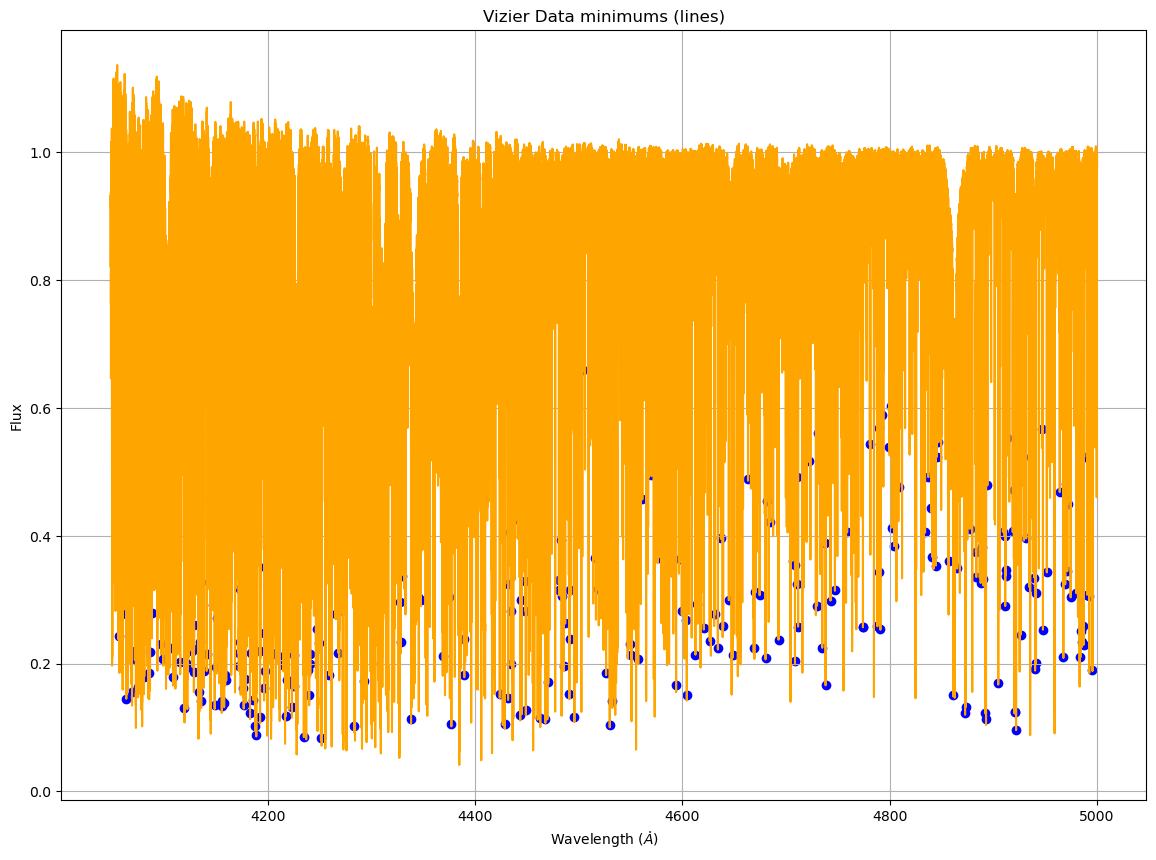

In [98]:
#Find the minimum or the lambda in the spectrum
x = data_4000_5000['Wave A']
y = data_4000_5000['nFlux']
l = lambda_4000_5000['lambda']
mini, _ = find_peaks(-y) #For the minimums
mindf = pd.DataFrame([])
mindf['minx'] = x[mini]
mindf['miny'] = y[mini]

#Take the closer line with an abs
mar=[]

for i in l:
    mindf['abs'] = np.abs(mindf['minx']-i)
    mar.append(mindf.loc[mindf['abs'] == min(mindf['abs'])])

#Dataframe with the marks
mardf = pd.concat(mar,axis=0).reset_index(drop=True).drop(['abs'],axis=1)
  
fig3, ax = plt.subplots(1,1,figsize=(14,10))
ax.plot(x,y, color='orange')
ax.scatter(mardf['minx'],mardf['miny'], color='blue')
ax.set_title('Vizier Data minimums (lines)')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

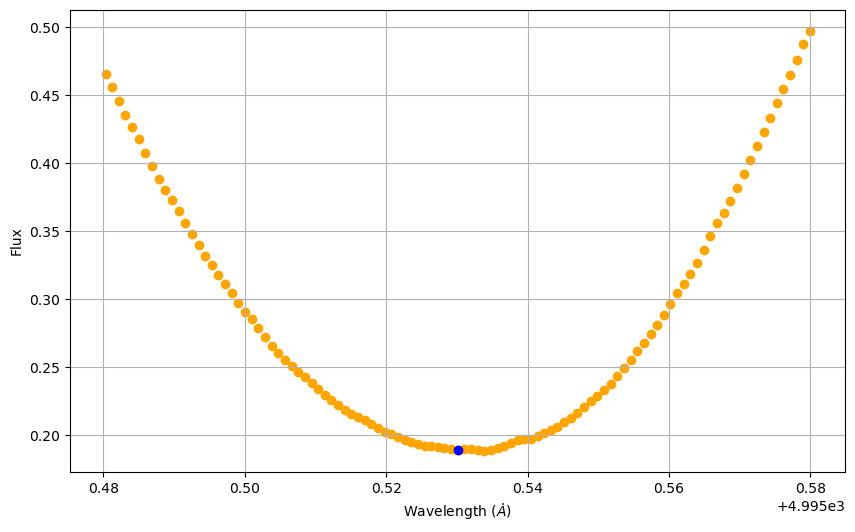

In [99]:
#Localize the line and save the 100 mA width
local =[]
for each in mardf['minx']:
    local.append(data_4000_5000[data_4000_5000['Wave A'].between(each-0.05, each+0.05, inclusive='neither')])

fig4, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(local[-1]['Wave A'],local[-1]['nFlux'], color='orange')
ax.scatter(mardf['minx'][len(mardf['minx'])-1],mardf['miny'][len(mardf['minx'])-1], color='blue')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

### Derivates

¿Por qué se escalan los datos?
Problema de condición numérica:

Cuando los valores de x son muy grandes (ej. 1000, 2000, ...), términos como x⁴ generan números extremadamente grandes (ej. 1000⁴ = 1e12)

Esto crea una matriz de Vandermonde mal condicionada

Desequilibrio entre términos:

Los términos de alto grado dominan numéricamente sobre los de bajo grado

Ejemplo: En 1e12*x⁴ + 1e3*x³ + x², el término cuadrático se vuelve insignificante

¿Por qué no afecta al resultado final?
El escalado es una transformación lineal reversible:

El polinomio ajustado es matemáticamente equivalente

Las predicciones son exactamente las mismas

Solo cambia la representación numérica interna durante el cálculo

In [103]:
#PlayData for automatice the code
datax = local[100]['Wave A']
datay = local[100]['nFlux']

markx = mardf['minx'][1]
marky = mardf['miny'][1]

datax

371269    4291.534529
371270    4291.535223
371271    4291.535916
371272    4291.536610
371273    4291.537304
             ...     
371409    4291.631648
371410    4291.632342
371411    4291.633035
371412    4291.633729
371413    4291.634423
Name: Wave A, Length: 145, dtype: float64

(0.11329104407544133, 0.269676489000861)

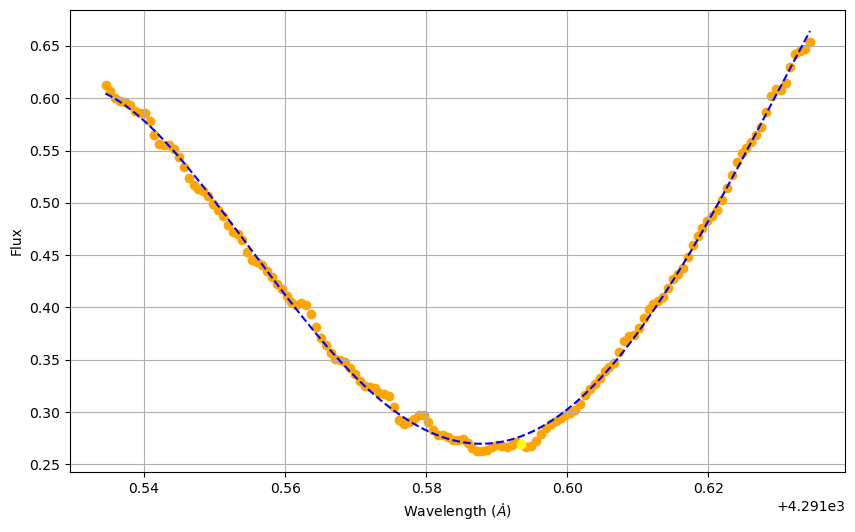

In [104]:
#Intern escalation


x=datax
y=datay

x_mean, x_std = np.mean(x), np.std(x)
x_scaled = (x - x_mean)/x_std if x_std != 0 else x
    
#Polynomial Fit is better for aproximation
poli = Polynomial.fit(x_scaled, y, 4)
    
param = poli.convert().coef

def poly_func(x_new):
        x_new_scaled = (np.asarray(x_new) - x_mean)/x_std if x_std != 0 else x_new
        return np.polyval(param[::-1], x_new_scaled)

y_pred = poly_func(x) #fit

#Calculate the derivates without evaluate the point
d_param = poly.polyder(param) #First
d2_param = poly.polyder(d_param) #Second
d3_param = poly.polyder(d2_param) #Third

#Find the minimum with the regression and derivates
roots = poly.polyroots(d_param).real#roots or critical points
valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] ) #check with the second derivate
value_roots = poli(valid_roots)
minimal_root = valid_roots[np.where(value_roots == min(poli(roots)))][0] , min(value_roots) #hallar los valores de minimo

data = pd.DataFrame([])
data['wave'] = datax
data['flux'] = datay

data['abs'] = np.abs(data['flux']-minimal_root[1]) #como use la misma datax para hallar todo puedo hacer un dataframe

lamda = []
lamda.append(data.loc[data['abs'] == min(data['abs'])]) #esta es la lambda natural

#ahora si evaluo en el punto
def formula_profe(seg, ter):
    return -((ter)/(3*(seg**2)))

#Evaluate in the point
d2 = poly.polyval(lamda[0]['wave'],d2_param)
d3 = formula_profe(d2, poly.polyval(lamda[0]['wave'],d3_param))
d3.iloc[0]

#Graphic with fot and the minimal point with the regresion
fig4, ax = plt.subplots(1,1,figsize=(10,6))
ax.scatter(datax,datay, color='orange')
ax.plot(datax,y_pred,'--',color='blue')
ax.scatter(lamda[0]['wave'],lamda[0]['flux'],color='yellow')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

minimal_root

In [ ]:
C = 299792458
round((((lamda[0]['wave']/lambda_4000_5000['lambda'][1]) - 1) * C) - 633)